# Common Pitfalls in Model Coefficient Interpretation.
This examples comes from the scikit-learn docs [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py).

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

Our data comes from `OpenML` and is a dataset of wages (explore the dataset to see exactly what it contains)

In [91]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

c:\Users\shayl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In the dataset, the x and y variables are already predecided, we just need to extract them and add it to a variable for easy use.

In [92]:
survey.data.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [93]:
X = survey.data[survey.feature_names]
X.describe(include = "all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [94]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

Now, split the data into train and test

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # We can specify a test_size which is the proportion to attribute to the test set (between 0 and 1)

Let's look at the variable distributions in the test set

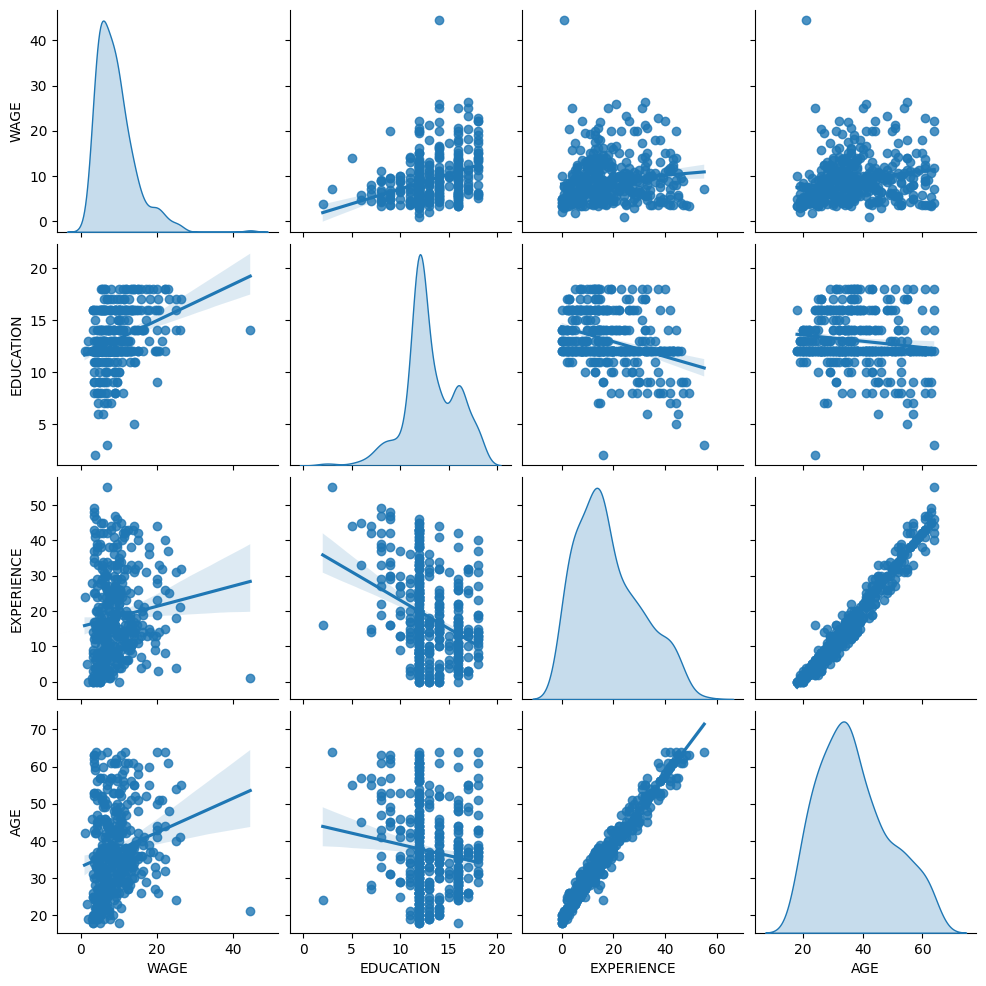

In [96]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train) #Insert wages back into dataset
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

Based on this, we can see that `wage` has quite a long tail so we need to apply a `log` transformation to it to get it to approximate a normal distribution. There is also a very strong correlation between `age` and `experience` (so our model would likely eliminate one)

Now, let's peek into the types of data. We have a combination of categorical and numerical. The categorical variables would have to be one-hot encoded.

In [97]:
survey.data.dtypes

EDUCATION        int64
SOUTH         category
SEX           category
EXPERIENCE       int64
UNION         category
AGE              int64
RACE          category
OCCUPATION    category
SECTOR        category
MARR          category
dtype: object

Let's do the transformations

In [98]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = survey.data.dtypes[survey.data.dtypes == "category"].index
numerical_columns = survey.data.dtypes[survey.data.dtypes == "int64"].index

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns), #Send categorical variables to one-hot encoder while dropping the binary variables.
    remainder="passthrough", #The rest of the dataset
    verbose_feature_names_out=False, #avoids prepending the preprocessor names
)

We now model the dataset as a linear model with a Ridge penalty with very small regularization. Keep in mind, that we said we should use the log of wage. We create a pipeline that firsts preprocesses the data, then applies transformation.

In [99]:
from sklearn.compose import TransformedTargetRegressor #Useful for applying a transformation to Y. We specity the transformation (func) and the inverse of that function.
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

Now, train the model. We should see the pipeline after this.

In [100]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

We can now go ahead and check the performance of the model

In [101]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
print("mae_train:", mae_train)
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_pred, y_test)
print("mae_test:", mae_test)

mae_train: 2.140282931919243
mae_test: 2.224855504721017


Print the predicted vs actual y's. Clearly, we fail at predicting high y's

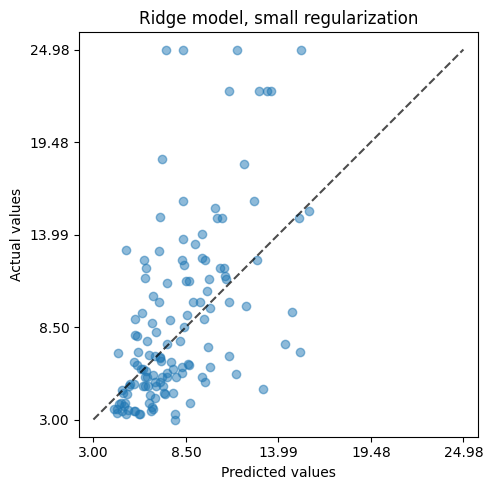

In [102]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
plt.tight_layout()

# Interpreting Coefficients:
## Impact of Scale

Let's start by looking at the coefficients we got from the model. Note: `model[-:1]` just removes the last step of the pipeline i.e. keeps transformations. We can then transform what we need to by using `.transform(x)`

In [103]:
model[:-1]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object'))],
                                   verbose_feature_names_out=False))])

In [104]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
SOUTH_yes,-0.033823
SEX_male,0.090808
UNION_not_member,-0.117154
RACE_Hispanic,-0.013521
RACE_Other,-0.009077
RACE_White,0.022592
OCCUPATION_Clerical,0.000050
OCCUPATION_Management,0.090532
OCCUPATION_Other,-0.025097
OCCUPATION_Professional,0.071968


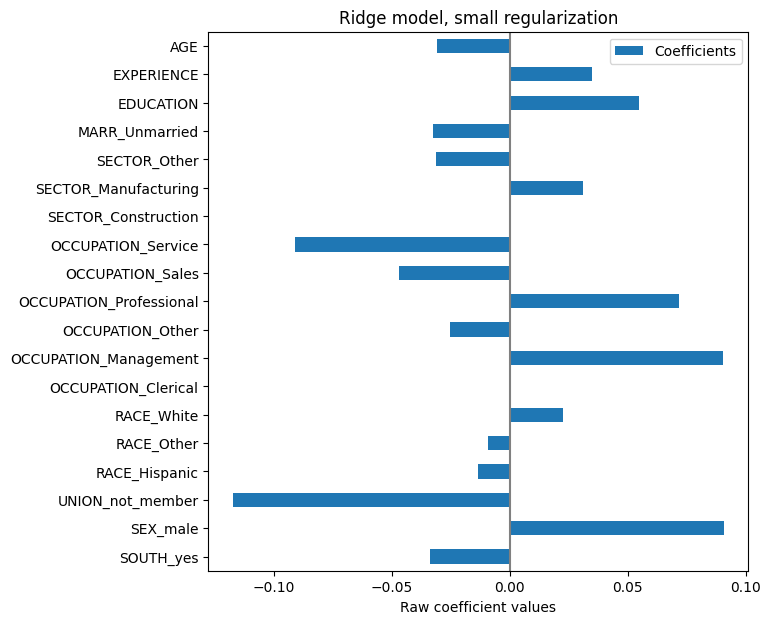

In [105]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

We can see that apparently the most important variable seems to be union which doesn't seem right, surely something like experience would have more of an impact (this is where an understanding of the problem domain comes in). So, using a coefficient plot like this to judge variable importance can be misleading because the scale differs so much e.g. age varies by decades where union is either yes or no.

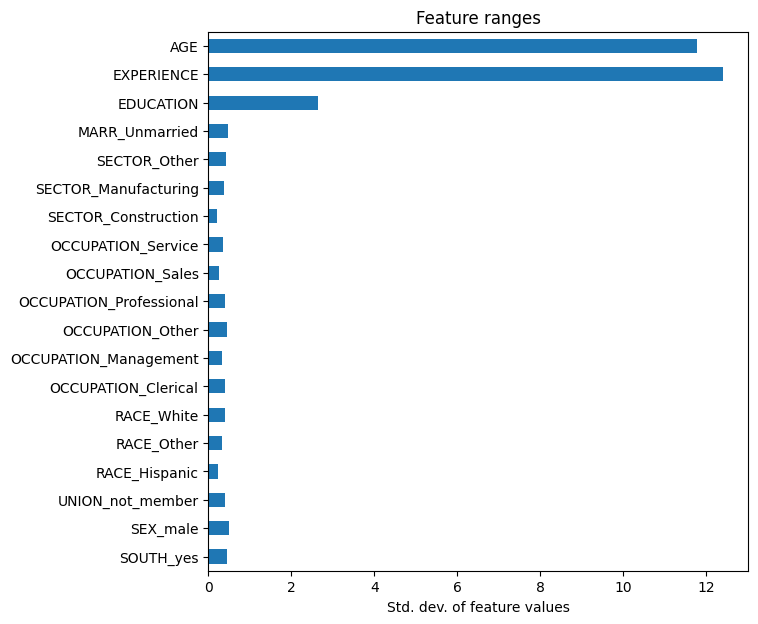

In [106]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

We can see that the standard deviations of age and experience is quite high (as expected). So, to get a better idea of variable importance, we will multiply each coefficient by its standard deviation. This is equivalent to normalizing numerical variables.

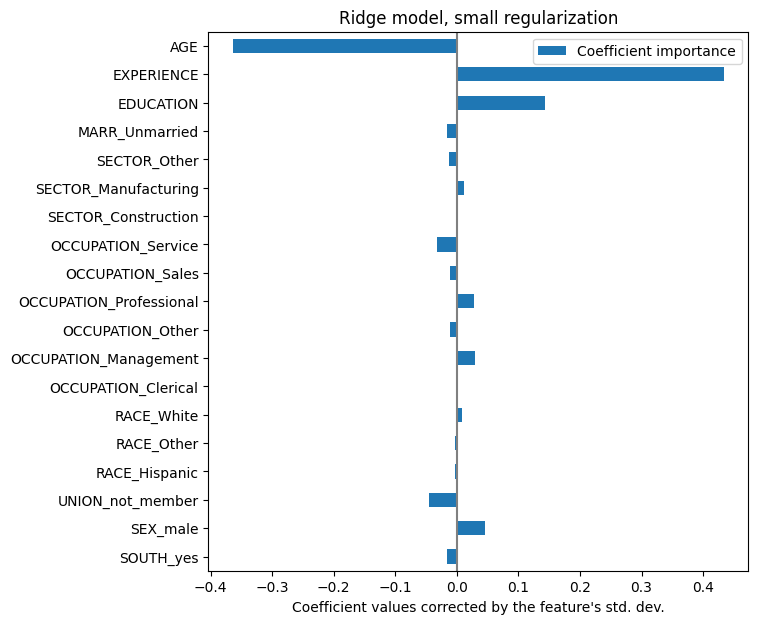

In [107]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(), #Just added the standard deviations in
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)




We can now see that `Age`, Experience and Education are indeed the most important variables. Note, this graph tells us that an increase in age leads to a decrease in salary but our initial plot shows the opposite. This is because the coefficients only take into account `conditional dependencies` i.e. everything else is constant.

## Coefficient Variability
We can test this through cross validation

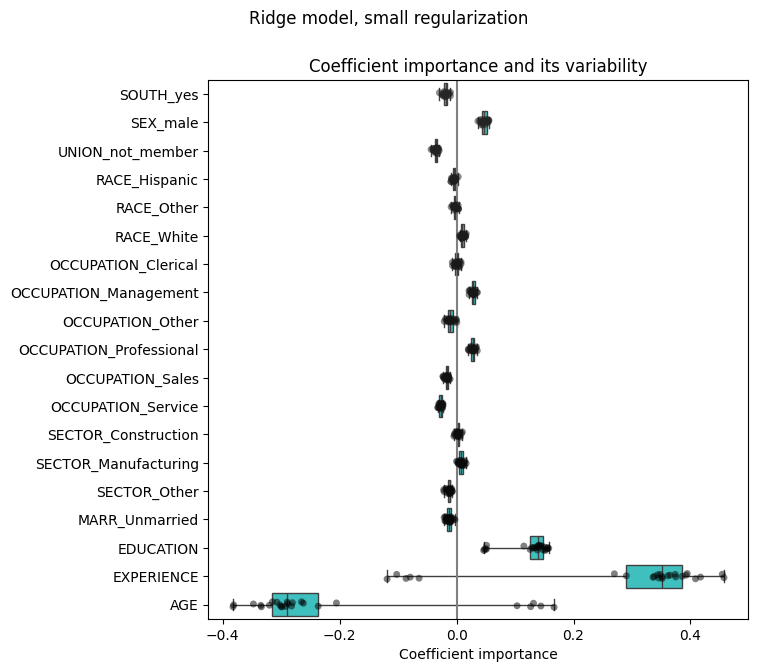

In [108]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(model, X, y, cv = cv, return_estimator=True, n_jobs = 2)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

# Making the changes
We now keep the model the same but add a standardization step to the preprocessor

In [109]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns), #Send categorical variables to one-hot encoder while dropping the binary variables.
    (StandardScaler(), numerical_columns)
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['EDUCATION', 'EXPERIENCE', 'AGE'], dtype='object'))])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

We do the same evaluation as before.

mae_train: 2.1402829319088923
mae_test: 2.2248555047374956


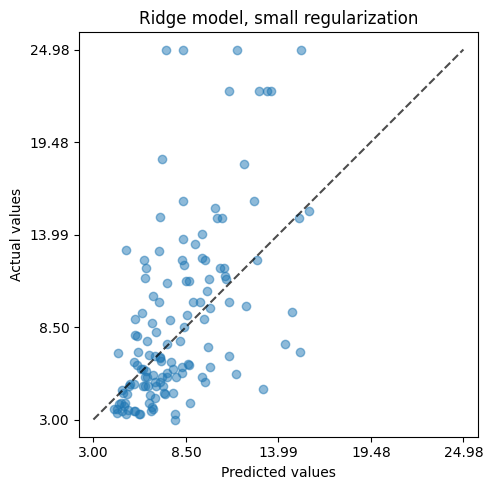

In [110]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
print("mae_train:", mae_train)
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_pred, y_test)
print("mae_test:", mae_test)
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
plt.tight_layout()

For the coefficient analysis, we do not need a scaling step as this was done in preprocessing

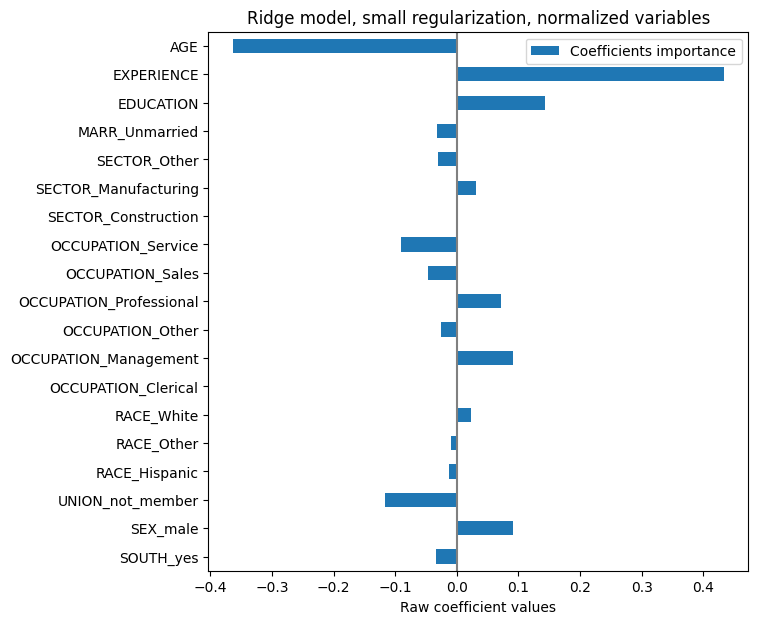

In [111]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Again, no scaling in this part :)

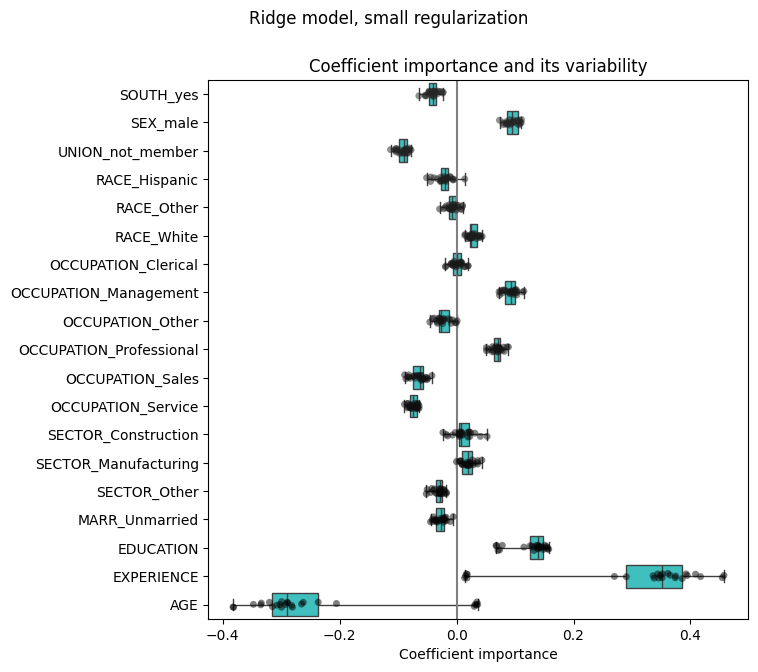

In [112]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(model, X, y, cv = cv, return_estimator=True, n_jobs = 2)

coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

Our results are quite similar to the unnormalized case!

# Some more regularization
We do a CV search of regularization parameters

In [113]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model.fit(X_train, y_train)
print("Selected Alpha:", model[-1].regressor_.alpha_)

Selected Alpha: 10.0


mae_train: 2.1373191058640466
mae_test: 2.0889150755806623


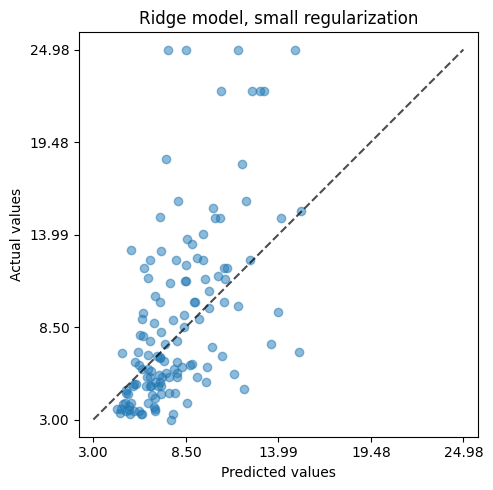

In [114]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
print("mae_train:", mae_train)
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_pred, y_test)
print("mae_test:", mae_test)
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
plt.tight_layout()

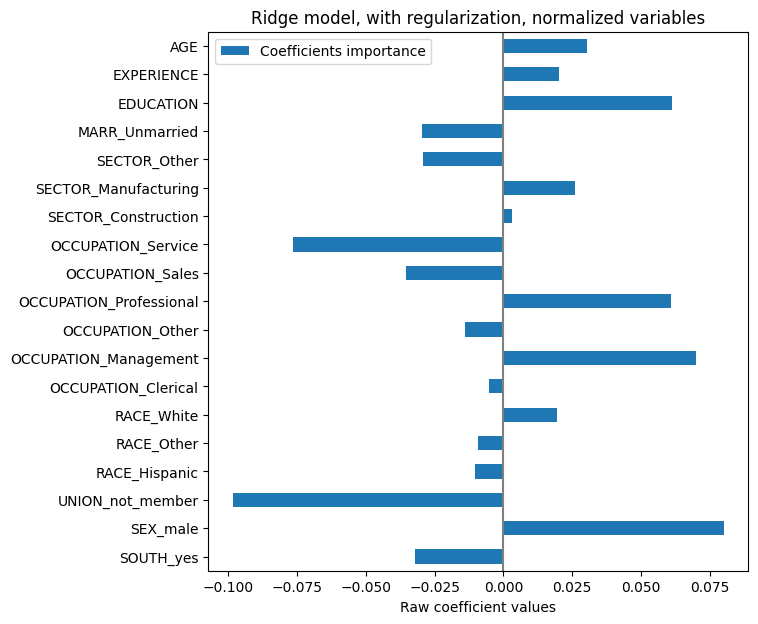

In [115]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Now, `Age` and `Experience` are both positive but have less of an influence on the prediction: The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.